# [機械学習/深層学習] 多層パーセプトロンを実装してMNISTの分類


In [48]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(34)

In [49]:
def relu(x):
    return np.maximum(x, 0)


def deriv_relu(x):
    return (x > 0).astype(x.dtype)

In [51]:
def softmax(x):
    x -= x.max(axis=1, keepdims=True)
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

In [50]:
def np_log(x):
    return np.log(np.clip(x, 1e-10, 1e+10))

In [52]:
(x_mnist_1, t_mnist_1), (x_mnist_2, t_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
t_mnist = np.r_[t_mnist_1, t_mnist_2]

x_mnist = x_mnist.astype("float64") / 255.
t_mnist = np.eye(N=10)[t_mnist.astype("int32").flatten()]

x_mnist = x_mnist.reshape(x_mnist.shape[0], -1)

x_train_mnist, x_test_mnist, t_train_mnist, t_test_mnist =\
    train_test_split(x_mnist, t_mnist, test_size=10000)
x_train_mnist, x_valid_mnist, t_train_mnist, t_valid_mnist =\
    train_test_split(x_train_mnist, t_train_mnist, test_size=10000)

In [53]:
class Dense:
    def __init__(self, in_dim, out_dim, function, deriv_function):
        # He initialization (for ReLU)
        self.W = (np.random.randn(in_dim, out_dim)
                  * np.sqrt(2.0 / in_dim)).astype("float64")
        self.b = np.zeros(out_dim).astype("float64")
        self.function = function
        self.deriv_function = deriv_function

        self.x = None
        self.u = None

        self.dW = None
        self.db = None


    def __call__(self, x):
        """
        順伝播処理を行うメソッド．
        x: (batch_size, in_dim_{j})
        h: (batch_size, out_dim_{j})
        """
        self.x = x
        self.u = np.matmul(self.x, self.W) + self.b
        h = self.function(self.u)
        return h

    def b_prop(self, delta, W):
        """
        誤差逆伝播を行うメソッド．
        delta (=delta_{j+1}): (batch_size, out_dim_{j+1})
        W (=W_{j+1}): (out_dim_{j}, out_dim_{j+1})
        self.delta (=delta_{j}): (batch_size, out_dim_{j})
        """
        self.delta = self.deriv_function(self.u) * np.matmul(delta, W.T)
        return self.delta

    def compute_grad(self):
        """
        勾配を計算するメソッド．
        self.x: (batch_size, in_dim_{j})
        self.delta: (batch_size, out_dim_{j})
        self.dW: (in_dim_{j}, out_dim_{j})
        self.db: (out_dim_{j})
        """
        batch_size = self.delta.shape[0]

        lambda_ = 1e-4
        self.dW = (np.matmul(self.x.T, self.delta) / batch_size
                   + lambda_ * self.W)
        self.db = np.matmul(np.ones(batch_size), self.delta) / batch_size

In [54]:
class Model:
    def __init__(self, hidden_dims, activation_functions, deriv_functions):
        """
        :param hiden_dims: List[int]，各層のノード数を格納したリスト．
        :params activation_functions: List, 各層で用いる活性化関数を格納したリスト．
        :params derive_functions: List，各層で用いる活性化関数の導関数を格納したリスト．
        """
        # 各層をリストに格納していく
        self.layers = []
        for i in range(len(hidden_dims)-2):  # 出力層以外は同じ構造
            self.layers.append(Dense(hidden_dims[i], hidden_dims[i+1],
                                     activation_functions[i], deriv_functions[i]))
        self.layers.append(Dense(hidden_dims[-2], hidden_dims[-1],
                                 activation_functions[-1], deriv_functions[-1]))  # 出力層を追加

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        """順伝播処理を行うメソッド"""
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, delta):
        """誤差逆伝播，勾配計算を行うメソッド"""

        for i, layer in enumerate(self.layers[::-1]):
            if i == 0:  # 出力層の場合
                layer.delta = delta  # y - t
                layer.compute_grad()
            else:  # 出力層以外の場合
                delta = layer.b_prop(delta, W)  # 逆伝播
                layer.compute_grad()  # 勾配の計算

            W = layer.W

    def update(self, eps=0.01):
        """パラメータの更新を行うメソッド"""
        for layer in self.layers:
            layer.W -= eps * layer.dW
            layer.b -= eps * layer.db

In [55]:
model = Model(hidden_dims=[784, 256, 128, 10],
              activation_functions=[relu, relu, softmax],
              deriv_functions=[deriv_relu, deriv_relu, deriv_softmax])

In [56]:
def create_batch(data, batch_size):
    """
    :param data: np.ndarray，入力データ
    :param batch_size: int，バッチサイズ
    """
    num_batches, mod = divmod(data.shape[0], batch_size)
    batched_data = np.split(data[: batch_size * num_batches], num_batches)
    if mod:
        batched_data.append(data[batch_size * num_batches:])

    return batched_data

In [57]:
def train_mst(model, x, t, eps=0.01):
    # 順伝播
    y = model(x)

    # 誤差の計算
    cost = (-t * np_log(y)).sum(axis=1).mean()

    # 逆伝播
    delta = y - t
    model.backward(delta)

    # パラメータの更新
    model.update(eps)

    return cost

In [58]:
def valid_mst(model, x, t):
    # 順伝播
    y = model(x)

    # 誤差の計算
    cost = (-t * np_log(y)).sum(axis=1).mean()

    return cost, y

In [59]:
# バッチサイズを指定
batch_size = 128

for epoch in range(30):
    x_train_mnist, t_train_mnist = shuffle(x_train_mnist, t_train_mnist)
    x_train_batch, t_train_batch = \
        create_batch(x_train_mnist, batch_size), create_batch(t_train_mnist, batch_size)
    # ミニバッチ学習
    for x, t in zip(x_train_batch, t_train_batch):
        cost = train_mst(model, x, t, eps=0.01)

    cost, y_pred = valid_mst(model, x_valid_mnist, t_valid_mnist)
    accuracy = accuracy_score(t_valid_mnist.argmax(axis=1), y_pred.argmax(axis=1))
    print(f"EPOCH: {epoch+1} Valid COST: {cost:.3f} Valid ACC: {accuracy:.3f}")

EPOCH: 1 Valid Cost: 0.552 Valid Accuracy: 0.867
EPOCH: 2 Valid Cost: 0.397 Valid Accuracy: 0.893
EPOCH: 3 Valid Cost: 0.344 Valid Accuracy: 0.907
EPOCH: 4 Valid Cost: 0.315 Valid Accuracy: 0.915
EPOCH: 5 Valid Cost: 0.294 Valid Accuracy: 0.920
EPOCH: 6 Valid Cost: 0.281 Valid Accuracy: 0.922
EPOCH: 7 Valid Cost: 0.267 Valid Accuracy: 0.926
EPOCH: 8 Valid Cost: 0.255 Valid Accuracy: 0.929
EPOCH: 9 Valid Cost: 0.246 Valid Accuracy: 0.931
EPOCH: 10 Valid Cost: 0.237 Valid Accuracy: 0.932


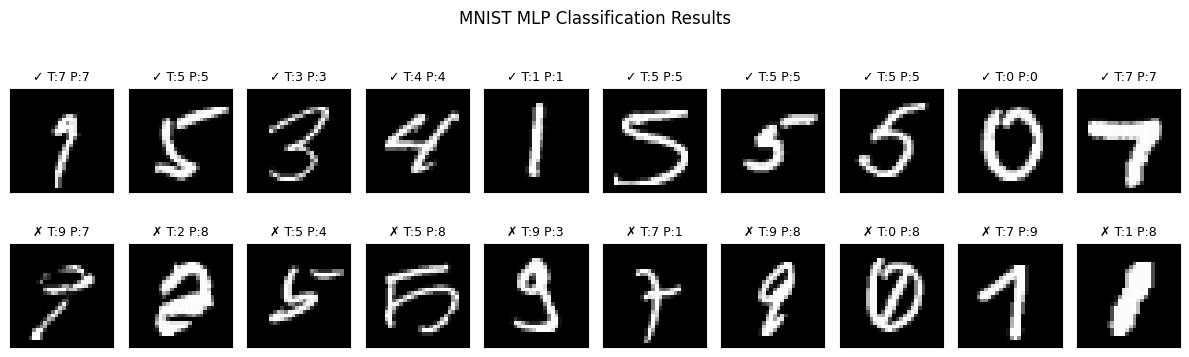

In [47]:
# ===== 予測 =====
_, y_pred = valid_mst(model, x_valid_mnist, t_valid_mnist)

y_true = t_valid_mnist.argmax(axis=1)
y_pred_label = y_pred.argmax(axis=1)

def show_correct_incorrect(x, y_true, y_pred, n=10):
    """
    正解・不正解を画像で表示
    上段: 正解, 下段: 不正解
    """
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]

    fig = plt.figure(figsize=(12, 4))

    # 正解例
    for i, idx in enumerate(correct_idx[:n]):
        ax = fig.add_subplot(2, n, i + 1, xticks=[], yticks=[])
        ax.imshow(x[idx].reshape(28, 28), cmap="gray")
        ax.set_title(f"✓ T:{y_true[idx]} P:{y_pred[idx]}", fontsize=9)

    # 不正解例
    for i, idx in enumerate(incorrect_idx[:n]):
        ax = fig.add_subplot(2, n, n + i + 1, xticks=[], yticks=[])
        ax.imshow(x[idx].reshape(28, 28), cmap="gray")
        ax.set_title(f"✗ T:{y_true[idx]} P:{y_pred[idx]}", fontsize=9)

    plt.suptitle("MNIST MLP Classification Results")
    plt.tight_layout()
    plt.show()

show_correct_incorrect(
    x_valid_mnist,
    y_true,
    y_pred_label,
    n=10
)